In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site
from hbmep.utils.constants import RECTIFIED_LOGISTIC

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/shap/adm.toml")

config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/J_SHAP/fix"

config.MCMC_PARAMS["num_chains"] = 20
config.MCMC_PARAMS["num_warmup"] = 10000

2023-08-15 10:38:35,055 - hbmep.config - INFO - Verifying configuration ...
2023-08-15 10:38:35,055 - hbmep.config - INFO - Success!


#### Load data and preprocess

In [3]:
class RectifiedLogistic(Baseline):
    LINK = RECTIFIED_LOGISTIC

    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0, ...].reshape(-1,)
        feature1 = features[1, ...].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]
        n_feature1 = np.unique(feature1).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(
                    site.mu_a,
                    dist.TruncatedNormal(150, 300, low=0)
                )
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(150))

                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(0.1))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(0.05))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(5))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    with numpyro.plate("n_feature1", n_feature1, dim=-4):
                        """ Priors """
                        a = numpyro.sample(
                            site.a,
                            dist.TruncatedNormal(mu_a, sigma_a, low=0)
                        )
                        b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                        L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                        H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                        v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                        g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                        g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))
                        c = numpyro.sample("c", dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[feature1, feature0, subject]
            + jnp.maximum(
                0,
                -1
                + (H[feature1, feature0, subject] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[feature1, feature0, subject], v[feature1, feature0, subject]) - 1)
                    * jnp.exp(-b[feature1, feature0, subject] * (intensity - a[feature1, feature0, subject])),
                    1 / v[feature1, feature0, subject]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[feature1, feature0, subject] + g_2[feature1, feature0, subject] * (1 / (mu + c[feature1, feature0, subject]))
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


model = RectifiedLogistic(config=config)

model.rng_key = jax.random.PRNGKey(model.random_state + 1)

2023-08-15 10:38:35,114 - hbmep.model.baseline - INFO - Initialized model with rectified_logistic link


In [4]:
df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Filter """
subset = [('50-0-50-0', 'C7L-', 'amap07')]
ind = df[model.combination_columns[::-1]].apply(tuple, axis=1).isin(subset)
df = df[ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)

""" Plot """
# model.plot(df=df, encoder_dict=encoder_dict)

2023-08-15 10:38:35,365 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/J_SHAP/fix
2023-08-15 10:38:35,366 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/J_SHAP/fix
2023-08-15 10:38:35,367 - hbmep.dataset.core - INFO - Processing data ...
2023-08-15 10:38:35,368 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


' Plot '

In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-08-15 10:38:35,496 - hbmep.model.baseline - INFO - Running inference with rectified_logistic ...


  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

2023-08-15 10:38:49,633 - hbmep.utils.utils - INFO - func:run_inference took: 14.14 sec


In [6]:
mcmc.print_summary(prob=.95)



                  mean       std    median      2.5%     97.5%     n_eff     r_hat
  H[0,0,0,0]      0.78      0.61      0.68      0.46      1.15   2882.57      1.01
  L[0,0,0,0]      0.04      0.01      0.04      0.03      0.05  34292.11      1.00
  a[0,0,0,0]    232.63      3.47    233.14    225.43    238.79   4292.94      1.00
  b[0,0,0,0]      0.10      0.07      0.09      0.01      0.23  26783.32      1.00
  c[0,0,0,0]     97.02     99.87     65.71      0.00    297.28  42646.80      1.00
g_1[0,0,0,0]     16.50      6.08     16.89      1.58     26.91  16208.61      1.00
g_2[0,0,0,0]     93.37     94.90     63.85      0.00    282.51  48887.50      1.00
  v[0,0,0,0]      2.83      3.36      1.68      0.00      9.46  22017.00      1.00
    µ_a[0,0]    223.69    102.24    225.77      0.00    400.57  51499.89      1.00
    σ_H[0,0]      2.67      2.26      1.93      0.22      7.35  19540.99      1.00
    σ_L[0,0]      0.05      0.02      0.04      0.01      0.10  48882.32      1.00
   

In [7]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-15 10:38:58,856 - hbmep.model.baseline - INFO - Generating predictions ...
2023-08-15 10:39:03,467 - hbmep.utils.utils - INFO - func:predict took: 4.61 sec
2023-08-15 10:39:03,486 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-08-15 10:39:04,305 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/J_SHAP/fix/recruitment_curves.pdf
2023-08-15 10:39:04,305 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.45 sec


In [8]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-15 10:39:04,423 - hbmep.model.baseline - INFO - Generating predictions ...


2023-08-15 10:39:09,315 - hbmep.utils.utils - INFO - func:predict took: 4.89 sec
2023-08-15 10:39:09,345 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-08-15 10:39:11,660 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/J_SHAP/fix/posterior_predictive_check.pdf
2023-08-15 10:39:11,662 - hbmep.utils.utils - INFO - func:render_predictive_check took: 7.24 sec


In [ ]:
model.save(mcmc=mcmc)

2023-08-09 00:36:59,874 - hbmep.model.baseline - INFO - Saving inference data ...
2023-08-09 00:37:42,949 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/L_SHIE/biceps/mcmc.nc
2023-08-09 00:37:42,950 - hbmep.model.baseline - INFO - Rendering convergence diagnostics ...
2023-08-09 00:38:52,426 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/L_SHIE/biceps/diagnostics.csv
2023-08-09 00:38:52,427 - hbmep.model.baseline - INFO - Evaluating model ...
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is le

#### Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


In [ ]:
model.features

['compound_position', 'compound_charge_params']

In [22]:
pos_classes = encoder_dict[model.features[0]].classes_.tolist()
pos_dict = {
    encoder_dict[model.features[0]].transform([pos])[0]: pos for pos in pos_classes
}

charge_classes = encoder_dict[model.features[1]].classes_.tolist()
charge_dict = {
    encoder_dict[model.features[1]].transform([charge])[0]: charge for charge in charge_classes
}

In [23]:
pos_dict

{0: '-C6LC', 1: 'C6LC-', 2: 'C6LC-C6LX', 3: 'C6LX-C6LC'}

In [24]:
charge_dict

{0: '20-0-80-25', 1: '50-0-50-100'}

In [25]:
model.combination_columns

['participant', 'compound_position', 'compound_charge_params']

In [31]:
a = np.array(posterior_samples[site.a])     # samples x charge x pos x participants x response
a_map = a.mean(axis=0)      # charge x pos x participants x response

combinations = model._make_combinations(df=df, columns=model.combination_columns)       # participant x pos x charge

conditions = model._make_combinations(df=df, columns=model.combination_columns[1:])     # pos x charge
n_conditions = len(conditions)

conditions_inv = [
    f"{pos_dict[pos]}::{charge_dict[charge]}" for (pos, charge) in conditions
]


In [32]:
rows = []
columns = ["left", "right", "pr"]

for i in range(n_conditions):
    (i_pos, i_ch) = conditions[i]

    curr_row = []

    for j in range(n_conditions):
        (j_pos, j_ch) = conditions[j]

        if i == j:
            curr_row.append(0)
            continue

        # Common participants
        common_participants = [part for (part, pos, ch) in combinations if pos == i_pos and ch == i_ch and (part, j_pos, j_ch) in combinations]

        curr_pr = 0
        for part in common_participants:
            samples = a[:, i_ch, i_pos, part, 0] - a[:, j_ch, j_pos, part, 0]
            pr = (samples < 0).mean()
            curr_pr += pr

        curr_row.append(curr_pr)

    rows.append(curr_row)

rows = np.array(rows)
rows /= n_conditions

<Axes: >

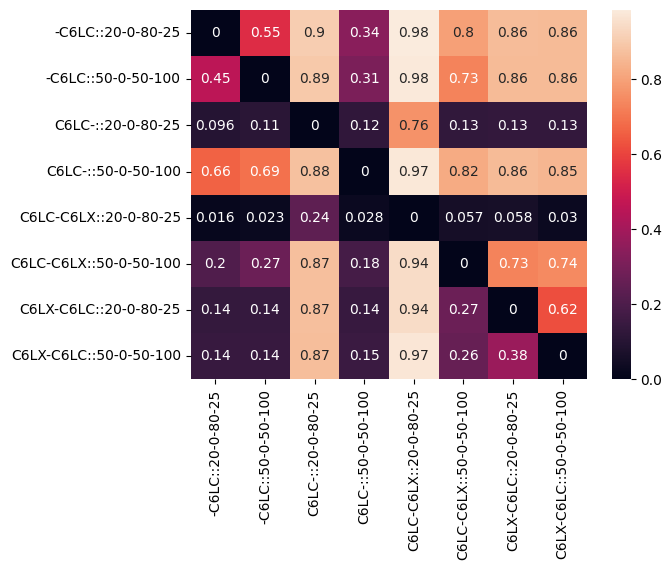

In [33]:
sns.heatmap(rows, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True)


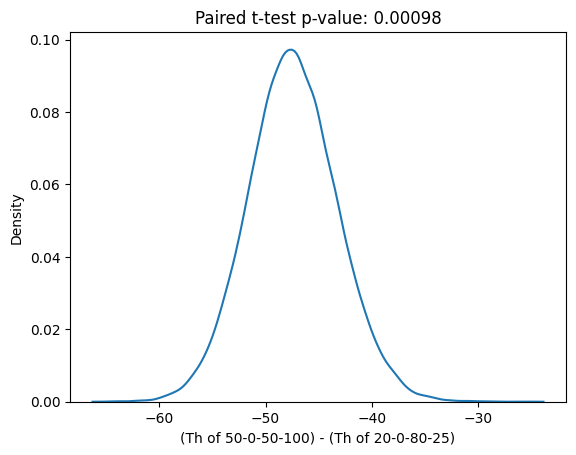

In [ ]:
common_ = [(part, pos, charge) for (part, pos, charge) in combinations if charge == 1 and (part, pos, 0) in combinations]

diff = []
for part, pos, charge in common_:
    samples = a[:, charge, pos, part, 0] - a[:, 0, pos, part, 0]
    diff.append(samples.tolist())

diff = np.array(diff)

sns.kdeplot(diff.mean(axis=0))
plt.xlabel(f"(Th of {charge_dict[1]}) - (Th of {charge_dict[0]})")

diff = []
for part, pos, charge in common_:
    samples = a_map[charge, pos, part, 0] - a_map[0, pos, part, 0]
    diff.append(samples)

pvalue = stats.ttest_1samp(a=diff, popmean=0, alternative="less").pvalue

plt.title(f"Paired t-test p-value: {pvalue:.02}");